## Задача 2. Сравнение методов классификации

Рыбина Екатерина Дмитриевна, 471 гр.

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random
import warnings

sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore') 
pd.set_option('display.precision', 4)
random.seed(19)
np.set_printoptions(precision=4)
np.random.seed(19)

[x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.

In [104]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array

MyKNN

In [105]:
class MyKnn(ClassifierMixin):
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        X = check_array(X)
        predictions = []
        for row in X:
            distances = self.calculate_distances(row)
            distances.sort(key=lambda tupl: tupl[1])
            neighbors_indx = self.get_neighbors(distances)
            label = self.get_popular_label(neighbors_indx)
            predictions.append(label)
        return predictions

    def calculate_distances(self, row):
        distances = list()
        length = len(row)
        for i, _row in enumerate(self.X):
            dist = 0.0
            for k in range(length - 1):
                dist += ((row[k] - _row[k])**2)
            dist = np.sqrt(dist)
            distances.append((i, dist))
        return distances

    def get_neighbors(self, distances):
        neighbors_indx = list()
        for i in range(self.n_neighbors):
            neighbors_indx.append(distances[i][0])
        return neighbors_indx
    
    def get_popular_label(self, neighbors):
        labels = []
        for i in neighbors:
            labels.append(self.y[i])
        label = max(set(labels), key=labels.count)
        return label

    def get_params(self, deep=True):
        return {"n_neighbors": self.n_neighbors}
    
    def set_params(self, **parameters):
        for param, value in parameters.items():
            setattr(self, param, value)
        return self

[x] * Реализовать еще один из методов классификации и добавить его в сравнение.

MySVM

In [106]:
class MySVM(ClassifierMixin):
    def __init__(self, alpha=0.001, lambd=0.01):
        self.alpha = alpha
        self.lambd = lambd
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X = X
        self.y = y
        self.update_weight()
        return self

    def predict(self, X):
        X = check_array(X)
        result = np.dot(X, self.W) - self.b
        predicted = np.sign(result)
        return np.where(predicted <= -1, 0, 1)

    def update_weight(self):
        y_labels = np.where(self.y <= 0, -1, 1)
        self.W = np.zeros(self.X.shape[1])
        self.b = 0
        for i, row_i in enumerate(self.X):
            delta_W = 0
            delta_b = 0
            if y_labels[i] * (np.dot(row_i, self.W) - self.b) >= 1:
                delta_W = 2*self.lambd*self.W
                delta_b = 0
            else:
                delta_W = 2*self.lambd*self.W - np.dot(row_i, y_labels[i])
                delta_b = y_labels[i]
            self.W = self.W - self.alpha*delta_W
            self.b = self.b - self.alpha*delta_b

    def get_params(self, deep=True):
        return {"alpha": self.alpha, "lambd": self.lambd}
    
    def set_params(self, **parameters):
        for param, value in parameters.items():
            setattr(self, param, value)
        return self

[x] Взять данные для предсказания заболеваний сердца 

[x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).

In [107]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [108]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [109]:
df["target"].value_counts()

1    526
0    499
Name: target, dtype: int64

В наборе данных нет пропущенных значений и количество с заболеванием и без примерно одинаково.

[x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.

In [110]:
df["sex"].value_counts()

1    713
0    312
Name: sex, dtype: int64

In [111]:
df.groupby(['sex', 'target'])['target'].count() 

sex  target
0    0          86
     1         226
1    0         413
     1         300
Name: target, dtype: int64

<AxesSubplot: xlabel='sex', ylabel='count'>

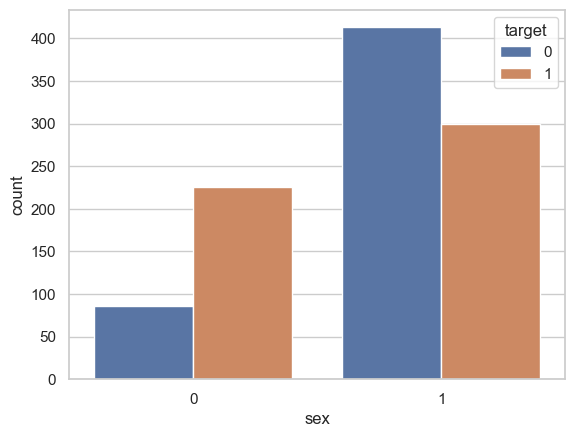

In [112]:
sns.countplot(x='sex', hue='target', data=df)

<AxesSubplot: xlabel='sex', ylabel='target'>

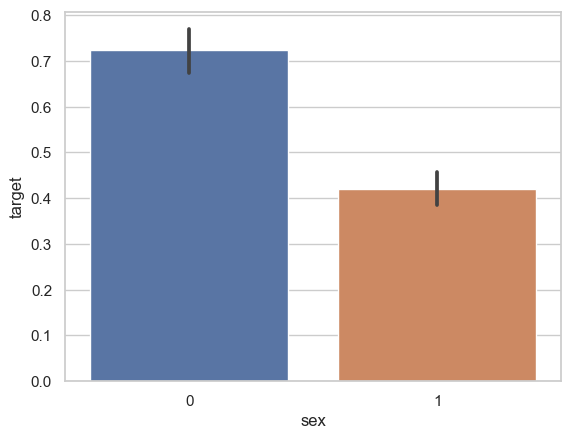

In [113]:
sns.barplot(x='sex', y='target', data=df)

Несмотря на то, что в данном наборе мужчин в два раза больше женщин, последние имеют большую вероятность иметь заболевание сердца.

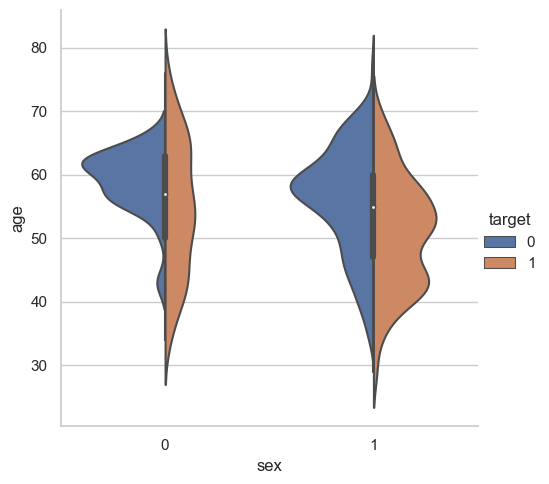

In [114]:
sns.catplot(data=df, kind="violin", x="sex", y="age", hue="target", split=True)

* Среди пациентов нет тех, кто моложе 29 лет
* У женщинс заболеванием почти нет зависимости от возраста
* Среди мужчин, диагноз имеют те у кого возраст 40-45 и 50-60

In [115]:
df["cp"].value_counts()

0    497
2    284
1    167
3     77
Name: cp, dtype: int64

<AxesSubplot: xlabel='cp', ylabel='count'>

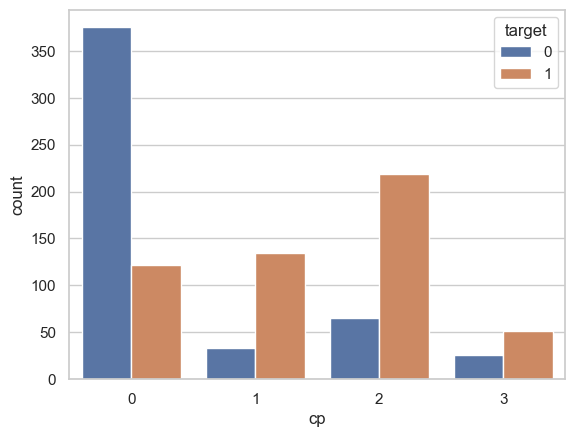

In [116]:
sns.countplot(x='cp', hue='target', data=df)

<AxesSubplot: xlabel='cp', ylabel='target'>

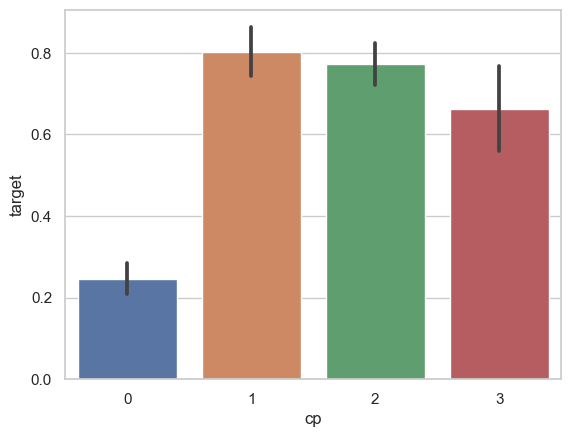

In [117]:
sns.barplot(x='cp', y='target', data=df)

В основном у пациентов с типом грудной боли 0 мало наблюдается заболевание сердца. 

[x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).

In [118]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope'])

df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,0,0,0,0,0,0,1,0,0,1
1,53,1,140,203,1,0,155,1,3.1,0,...,0,0,0,0,0,0,1,1,0,0
2,70,1,145,174,0,1,125,1,2.6,0,...,0,0,0,0,0,0,1,1,0,0
3,61,1,148,203,0,1,161,0,0.0,1,...,0,0,0,0,0,0,1,0,0,1
4,62,0,138,294,1,1,106,0,1.9,3,...,0,0,0,0,0,1,0,0,1,0


[x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.

#### Разбиение данных на тестовую и обучающую выборки

In [119]:
from sklearn.model_selection import train_test_split

X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Масштабирование данных

In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

#### Подбор наилучшего подмножества признаков

In [121]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifierCV

rfecv = RFECV(estimator=RidgeClassifierCV())
rfecv.fit(X_train_scaled, y_train)

print(f"Optimal numbers of feature: {rfecv.n_features_}")
features = list(X_train_scaled.columns[rfecv.support_])
print(f"Selected features: {features}")

Optimal numbers of feature: 15
Selected features: ['sex', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'thal_0', 'thal_2', 'thal_3', 'slope_1']


In [122]:
X_train_scaled = X_train_scaled[features]
X_test_scaled = X_test_scaled[features]

#### Подбор гиперпараметров

In [123]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(5, shuffle=True, random_state=19)

MyKNN

In [124]:
neighbors_grid = [3,5,7,9,11]

searcher_myknn = GridSearchCV(MyKnn(), [{"neighbors": neighbors_grid}], cv=cv)
searcher_myknn.fit(X_train_scaled, y_train)

optimal_n_neighbors = searcher_myknn.best_params_["neighbors"]
print(f"Neighbors: {optimal_n_neighbors}")

Neighbors: 3


MySVM

In [125]:
alpha_mysvm_grid = [0.001, 0.01, 0.1, 1]
lambd_mysvm_grid = [0.001, 0.01, 0.1, 1]

seracher_mysvm = GridSearchCV(MySVM(), [{"alpha": alpha_mysvm_grid,
                                         "lambd": lambd_mysvm_grid}], cv=cv)
seracher_mysvm.fit(X_train_scaled, y_train)

optimal_alpha_mysvm = seracher_mysvm.best_params_["alpha"]
print(f"Alpha: {optimal_alpha_mysvm}")
optimal_lambd_mysvm = seracher_mysvm.best_params_["lambd"]
print(f"Lambda: {optimal_lambd_mysvm}")

Alpha: 0.001
Lambda: 0.001


[x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).

KNN (библиотечная)

In [126]:
from sklearn.neighbors import KNeighborsClassifier

searcher_knn = GridSearchCV(KNeighborsClassifier(), [{"n_neighbors": neighbors_grid}], cv=cv)
searcher_knn.fit(X_train_scaled, y_train)

optimal_n_neighbors_knn = searcher_knn.best_params_["n_neighbors"]
print(f"Neighbors: {optimal_n_neighbors_knn}")

Neighbors: 3


SVM (библиотечная)

In [127]:
from sklearn.svm import SVC

kernel_grid = ["linear", "rbf"]
c_grid = [0.1, 0.25, 0.5, 0.75, 1]
gamma_grid = ["scale", "auto"]

searcher_svm = GridSearchCV(SVC(random_state=19), [{"kernel": kernel_grid, "C": c_grid, "gamma": gamma_grid}], cv=cv)
searcher_svm.fit(X_train_scaled, y_train)

optimal_kernel = searcher_svm.best_params_["kernel"]
print(f"Kernel: {optimal_kernel}")
optimal_c = searcher_svm.best_params_["C"]
print(f"C: {optimal_c}")
optimal_gamma = searcher_svm.best_params_["gamma"]
print(f"Gamma: {optimal_gamma}")

Kernel: rbf
C: 1
Gamma: scale


Logistic regression (библиотечная, LG)

In [128]:
from sklearn.linear_model import LogisticRegression

c_lg_grid = np.logspace(-3, 3, 10)

searcher_lg = GridSearchCV(LogisticRegression(), [{"C": c_lg_grid}], cv=cv)
searcher_lg.fit(X_train_scaled, y_train)

optimal_c_lg = searcher_lg.best_params_["C"]
print(f"C: {optimal_c_lg}")


C: 0.46415888336127775


Naive Bayes (библиотечная, NB)

In [129]:
from sklearn.naive_bayes import GaussianNB

var_smoothing_grid = np.logspace(0, -9)

sercher_nb = GridSearchCV(GaussianNB(), [{"var_smoothing" : var_smoothing_grid}], cv=cv)
sercher_nb.fit(X_train_scaled, y_train)

optimal_var_smoothing = sercher_nb.best_params_["var_smoothing"]
print(f"var_smoothing: {optimal_var_smoothing}")

var_smoothing: 0.281176869797423


Decision Tree (библиотечная, DT)

In [130]:
from sklearn.tree import DecisionTreeClassifier

max_depth_grid = range(1, 11)
min_samples_leaf_grid = [2, 4, 6]
min_samples_split_grid = [2, 6, 6]
params_dt = [{"max_depth": max_depth_grid,
              "min_samples_leaf": min_samples_leaf_grid,
              "min_samples_split": min_samples_split_grid}]

searcher_dt = GridSearchCV(DecisionTreeClassifier(random_state=19), params_dt, cv=cv)
searcher_dt.fit(X_train_scaled, y_train)

optimal_max_depth = searcher_dt.best_params_["max_depth"]
print(f"Max depth: {optimal_max_depth}")
optimal_min_samples_leaf = searcher_dt.best_params_["min_samples_leaf"]
print(f"Min samples leaf: {optimal_min_samples_leaf}")
optimal_min_samples_split = searcher_dt.best_params_["min_samples_split"]
print(f"Min samples split: {optimal_min_samples_split}")

Max depth: 8
Min samples leaf: 2
Min samples split: 2


[x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.

In [131]:
from sklearn.metrics import accuracy_score

accuracies = {}

MyKNN

In [132]:
classifier = MyKnn(optimal_n_neighbors)
classifier.fit(X_train_scaled, y_train)

y_test_myknn = classifier.predict(X_test_scaled)

accuracy_myknn = accuracy_score(y_test, y_test_myknn)
accuracies['MyKNN'] = accuracy_myknn
print(f"Test accuracy of MyKNN: {accuracy_myknn}")

Test accuracy of MyKNN: 0.9058441558441559


MySVM

In [133]:
classifier_mysvm = MySVM(alpha=optimal_alpha_mysvm, lambd=optimal_lambd_mysvm)
classifier_mysvm.fit(X_train_scaled, y_train)

y_test_mysvm = classifier_mysvm.predict(X_test_scaled)

accuracy_mysvm = accuracy_score(y_test, y_test_mysvm)
accuracies["MySVM"] = accuracy_mysvm
print(f"Test accuracy of MySVM: {accuracy_mysvm}")

Test accuracy of MySVM: 0.8409090909090909


KNN (библиотечная)

In [134]:
classifier_knn = KNeighborsClassifier(optimal_n_neighbors_knn)
classifier_knn.fit(X_train_scaled, y_train)

y_test_knn = classifier_knn.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_test_knn)
accuracies['KNN'] = accuracy_knn
print(f"Test accuracy of KNN: {accuracy_knn}")

Test accuracy of KNN: 0.9285714285714286


SVM (библиотечная)

In [135]:
classifier_svm = SVC(kernel=optimal_kernel, C=optimal_c, gamma=optimal_gamma, random_state=19)
classifier_svm.fit(X_train_scaled, y_train)

y_test_svm = classifier_svm.predict(X_test_scaled)

accuracy_svm = accuracy_score(y_test, y_test_svm)
accuracies['SVM'] = accuracy_svm
print(f"Test accuracy of SVM: {accuracy_svm}")

Test accuracy of SVM: 0.8733766233766234


Logistic regression (библиотечная)

In [136]:
classifier_lg = LogisticRegression(C=optimal_c_lg)
classifier_lg.fit(X_train_scaled, y_train)

y_test_lg = classifier_lg.predict(X_test_scaled)

accuracy_lg = accuracy_score(y_test, y_test_lg)
accuracies['LG'] = accuracy_lg
print(f"Test accuracy of LG: {accuracy_lg}")

Test accuracy of LG: 0.8116883116883117


Naive Bayes (библиотечная)

In [137]:
classifier_nb = GaussianNB(var_smoothing=optimal_var_smoothing)
classifier_nb.fit(X_train_scaled, y_train)

y_test_nb = classifier_nb.predict(X_test_scaled)

accuracy_nb = accuracy_score(y_test, y_test_nb)
accuracies['NB'] = accuracy_nb
print(f"Test accuracy of NB: {accuracy_nb}")

Test accuracy of NB: 0.8084415584415584


Decision Tree (библиотечная)

In [138]:
classifier_dt = DecisionTreeClassifier(max_depth=optimal_max_depth, 
                min_samples_leaf=optimal_min_samples_leaf, 
                min_samples_split=optimal_min_samples_split, 
                random_state=19)
classifier_dt.fit(X_train_scaled, y_train)

y_test_dt = classifier_dt.predict(X_test_scaled)

accuracy_dt = accuracy_score(y_test, y_test_dt)
accuracies['DT'] = accuracy_dt
print(f"Test accuracy of NB: {accuracy_dt}")

Test accuracy of NB: 0.948051948051948


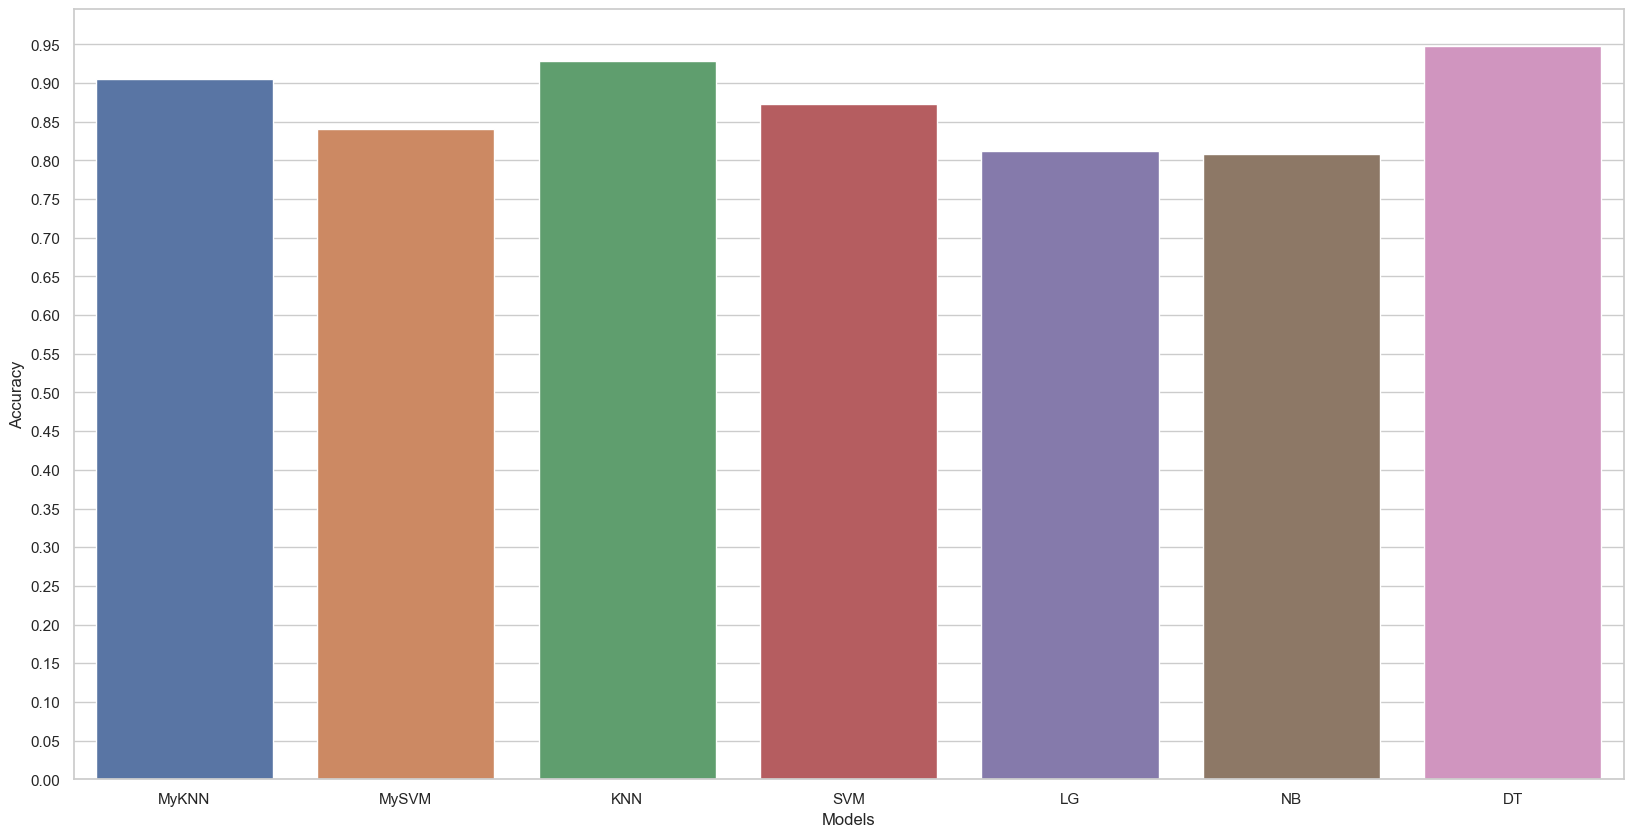

In [139]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.05, 0.05))

sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

In [140]:
from sklearn.metrics import confusion_matrix

my_knn_cm = confusion_matrix(y_test, y_test_myknn)
my_svm_cm = confusion_matrix(y_test, y_test_mysvm)
knn_cm = confusion_matrix(y_test, y_test_knn)
svm_cm = confusion_matrix(y_test, y_test_svm)
lg_cm = confusion_matrix(y_test, y_test_lg)
nb_cm = confusion_matrix(y_test, y_test_nb)
dt_cm = confusion_matrix(y_test, y_test_dt)

<AxesSubplot: title={'center': 'NB Confusion Matrix'}>

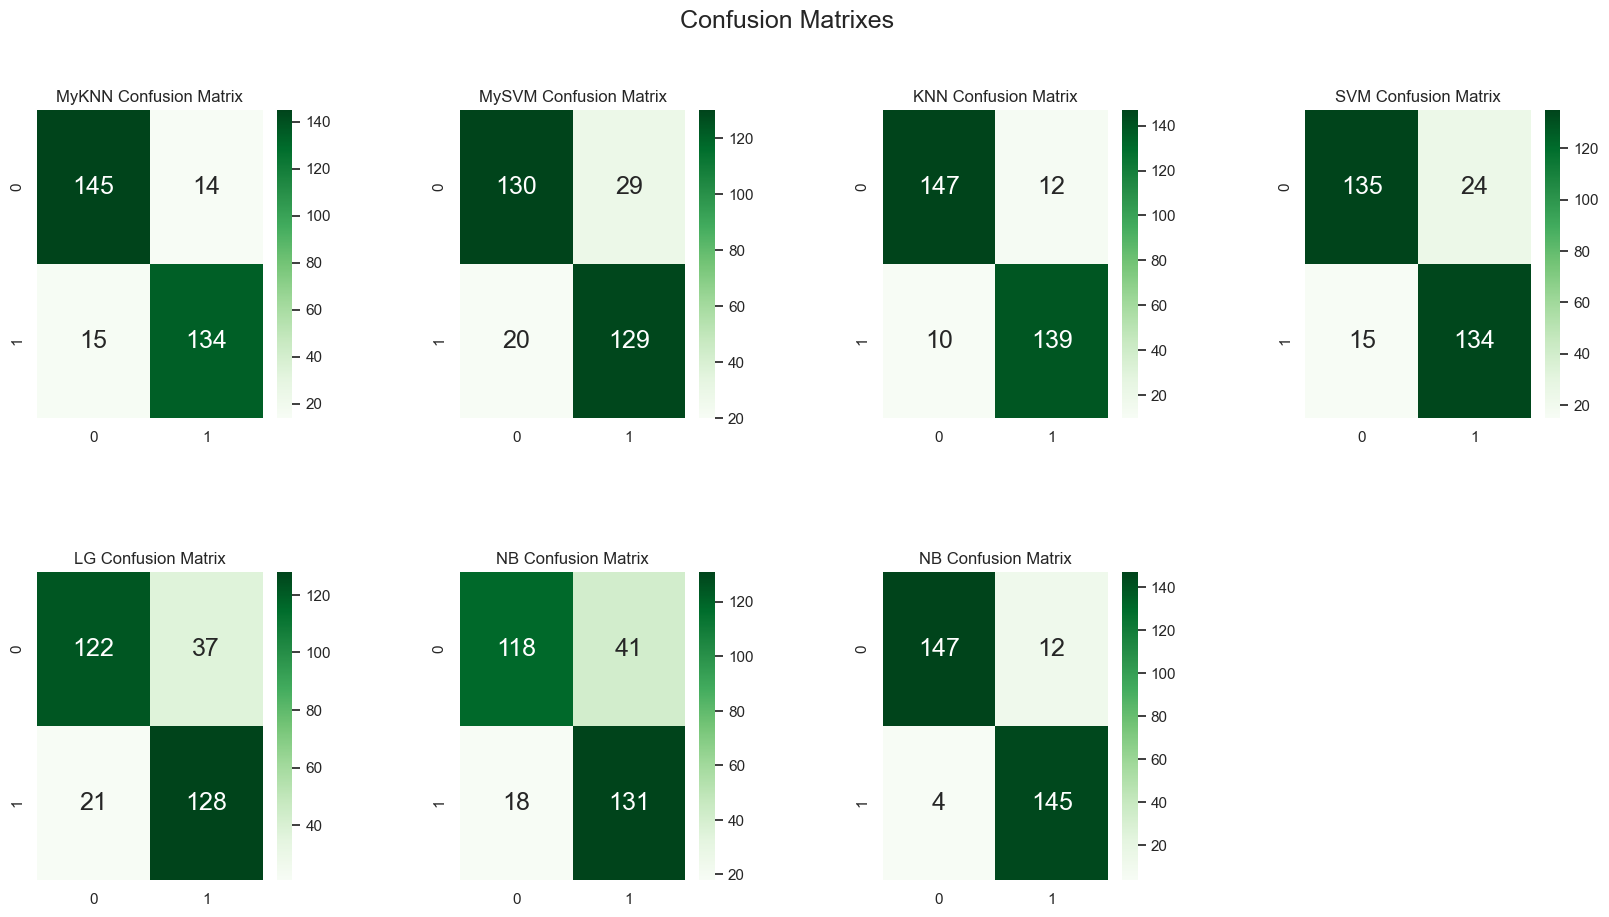

In [141]:
plt.figure(figsize=(20, 10))
plt.suptitle("Confusion Matrixes", fontsize=18)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2, 4, 1)
plt.title("MyKNN Confusion Matrix")
sns.heatmap(my_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 2)
plt.title("MySVM Confusion Matrix")
sns.heatmap(my_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 3)
plt.title("KNN Confusion Matrix")
sns.heatmap(knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 4)
plt.title("SVM Confusion Matrix")
sns.heatmap(svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 5)
plt.title("LG Confusion Matrix")
sns.heatmap(lg_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 6)
plt.title("NB Confusion Matrix")
sns.heatmap(nb_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 7)
plt.title("NB Confusion Matrix")
sns.heatmap(dt_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})


Выводы по первому набору данных:
* Собственные реализации KNN и SVM оказались близкими по точности к соответсвующим библиотечным моделям
* Самой точной моделью оказалась библиотечная Decision Tree
* Все модели показали точность результата больше 0.8